In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.api import VAR
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv("./Data/Advertising Budget and Sales.csv")
variables = ['TV Ad Budget ($)', 'Radio Ad Budget ($)', 'Newspaper Ad Budget ($)', 'Sales ($)']

print(df.shape)
df.head()

(200, 4)


,TV Ad Budget ($),Radio Ad Budget ($),Newspaper Ad Budget ($),Sales ($)
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [3]:
variables = ['TV Ad Budget ($)', 'Radio Ad Budget ($)', 'Newspaper Ad Budget ($)', 'Sales ($)']

# 각 값의 첫 값으로 정규화
df['Sales ($)'] = df['Sales ($)'] / df['Sales ($)'].iloc[0]
df['TV Ad Budget ($)'] = df['TV Ad Budget ($)'] / df['TV Ad Budget ($)'].iloc[0]
df['Radio Ad Budget ($)'] = df['Radio Ad Budget ($)'] / df['Radio Ad Budget ($)'].iloc[0]
df['Newspaper Ad Budget ($)'] = df['Newspaper Ad Budget ($)'] / df['Newspaper Ad Budget ($)'].iloc[0]

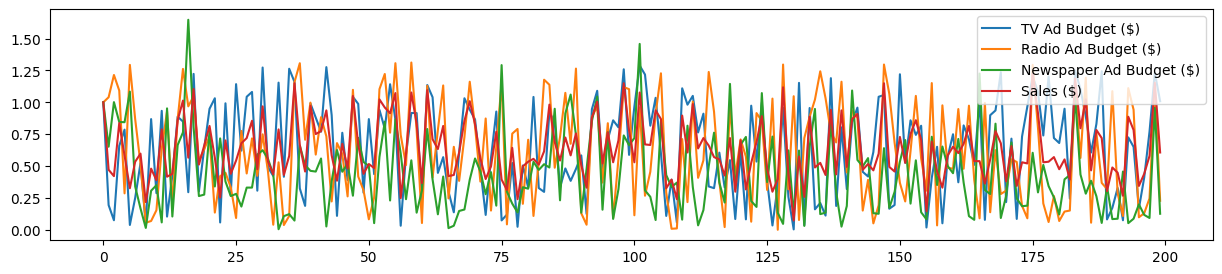

In [4]:
df.plot(figsize=(15,3))
plt.show()

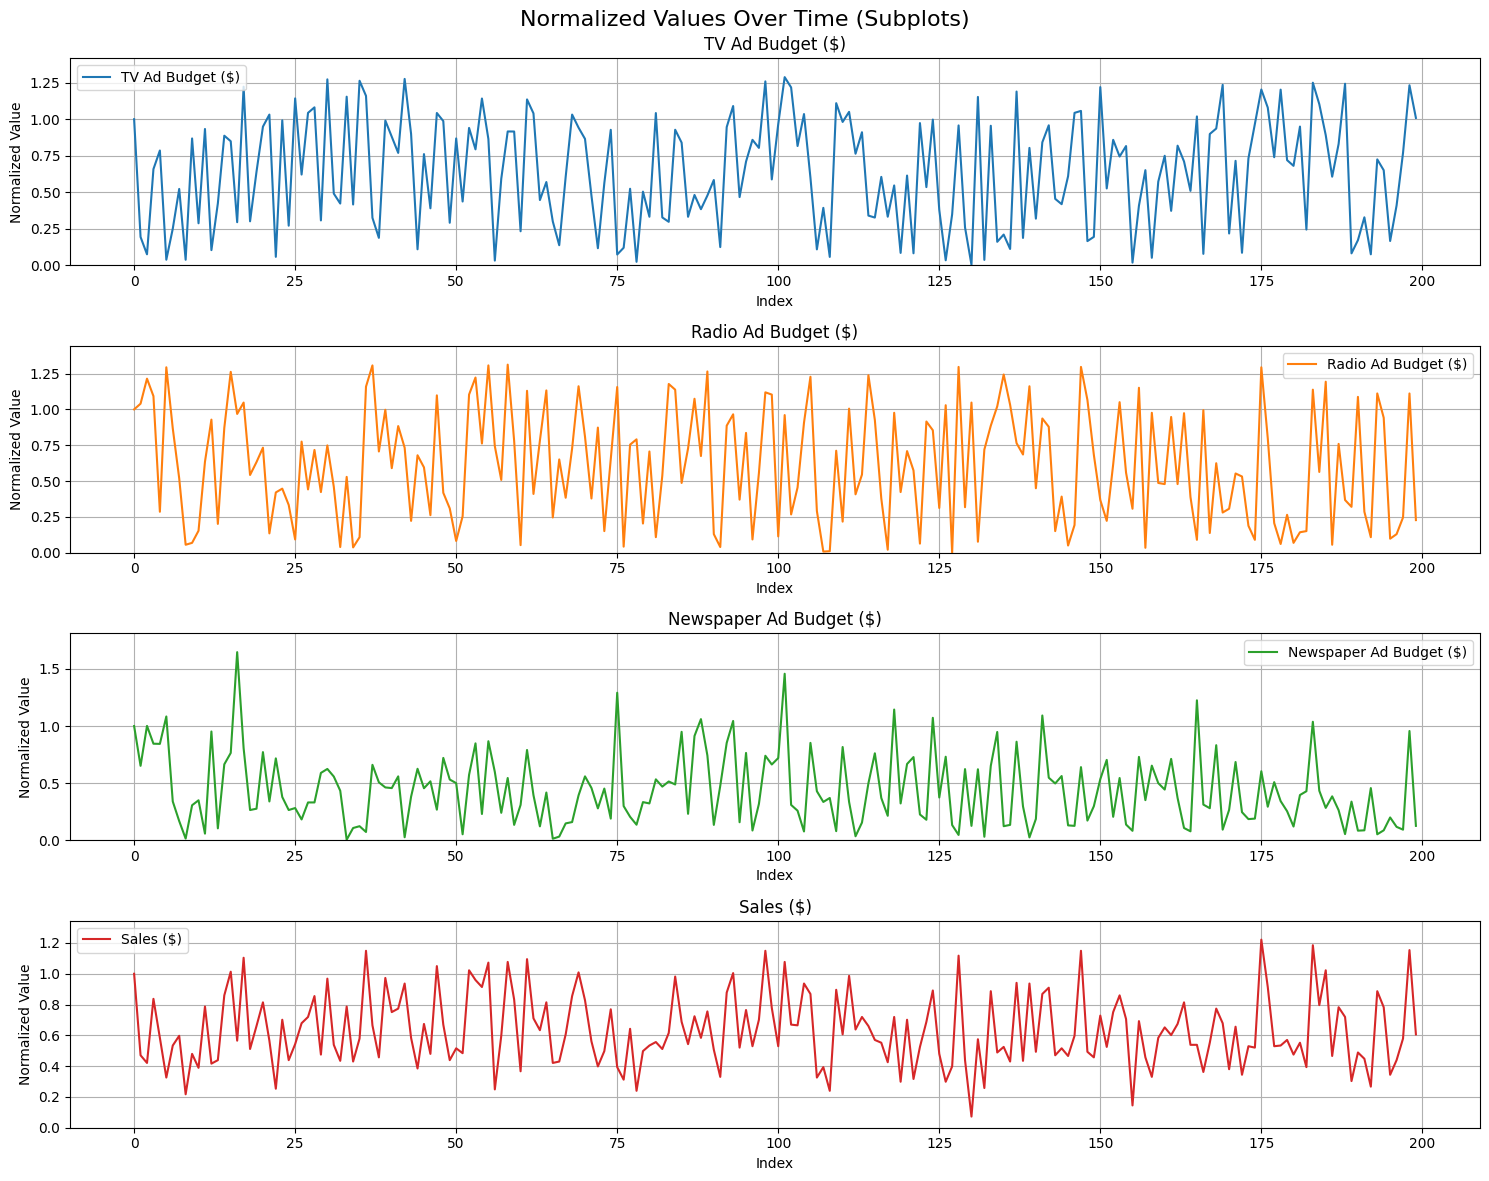

In [5]:
# matplotlib의 기본 색상 순서 사용
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# 각 변수를 별도의 서브플롯으로 그리기
fig, axes = plt.subplots(len(variables), 1, figsize=(15, 3*len(variables)))
fig.suptitle('Normalized Values Over Time (Subplots)', fontsize=16)

for i, var in enumerate(variables):
    axes[i].plot(df.index, df[var], label=var, color=colors[i])
    axes[i].set_title(var)
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Normalized Value')
    axes[i].legend()
    axes[i].grid(True)

    # y축 범위 설정 (0부터 데이터의 최대값까지)
    axes[i].set_ylim(0, df[var].max() * 1.1)  # 최대값에 10% 여유 추가

plt.tight_layout()
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

# ADF 테스트 함수 정의
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    return pd.Series({'Test Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]})

adf_results = {var: adf_test(df[var]) for var in variables}

# ADF 테스트 결과 출력 및 해석
for var, result in adf_results.items():
    print(f"\nADF Test Results for {var}:")
    print(result)
    
    if result['p-value'] <= 0.05:
        print(f"해석: {var}는 5% 유의수준에서 정상 시계열입니다.")
    else:
        print(f"해석: {var}는 5% 유의수준에서 비정상 시계열입니다.")


ADF Test Results for TV Ad Budget ($):
Test Statistic                                            -14.158141
p-value                                                          0.0
Critical Values    {'1%': -3.4636447617687436, '5%': -2.876176117...
dtype: object
해석: TV Ad Budget ($)는 5% 유의수준에서 정상 시계열입니다.

ADF Test Results for Radio Ad Budget ($):
Test Statistic                                            -14.129897
p-value                                                          0.0
Critical Values    {'1%': -3.4636447617687436, '5%': -2.876176117...
dtype: object
해석: Radio Ad Budget ($)는 5% 유의수준에서 정상 시계열입니다.

ADF Test Results for Newspaper Ad Budget ($):
Test Statistic                                            -13.344195
p-value                                                          0.0
Critical Values    {'1%': -3.4636447617687436, '5%': -2.876176117...
dtype: object
해석: Newspaper Ad Budget ($)는 5% 유의수준에서 정상 시계열입니다.

ADF Test Results for Sales ($):
Test Statistic                     

In [7]:
variables

['TV Ad Budget ($)',
 'Radio Ad Budget ($)',
 'Newspaper Ad Budget ($)',
 'Sales ($)']

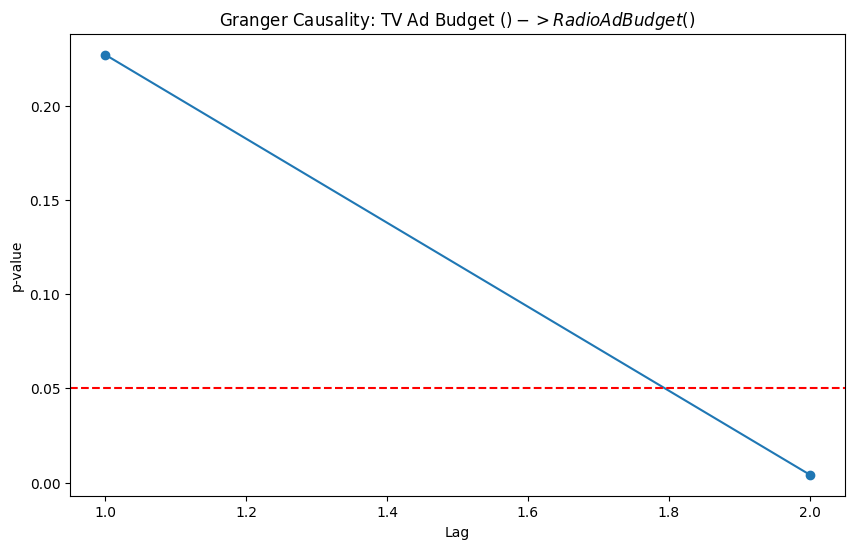

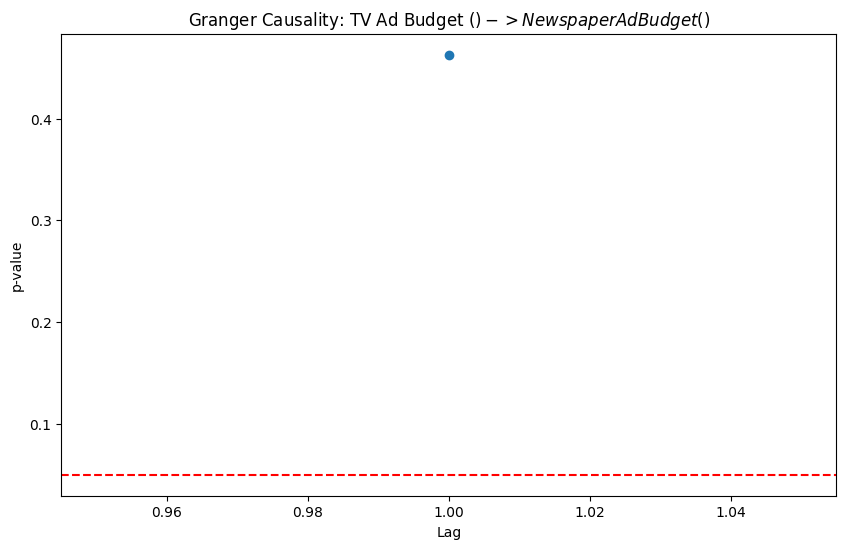

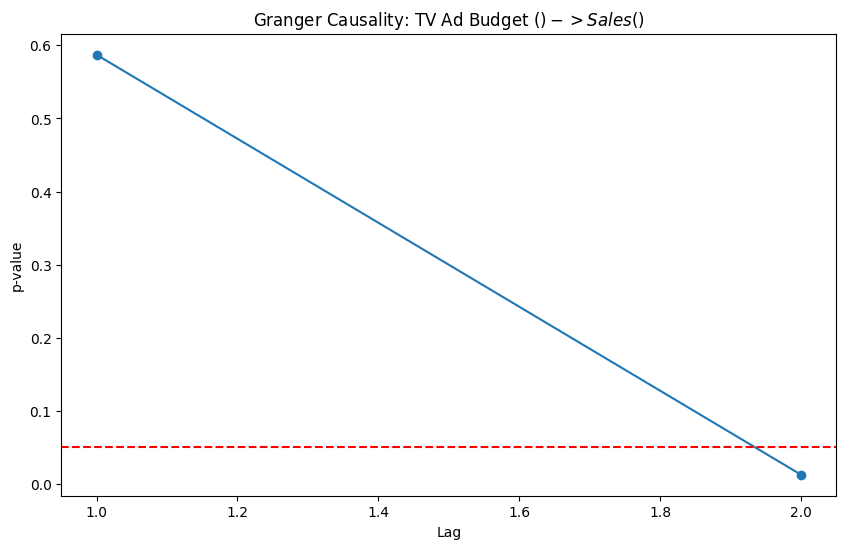

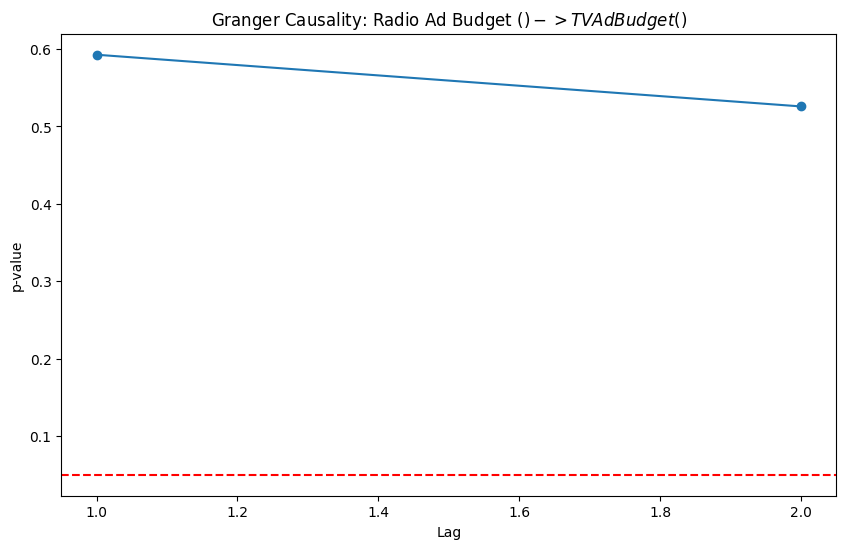

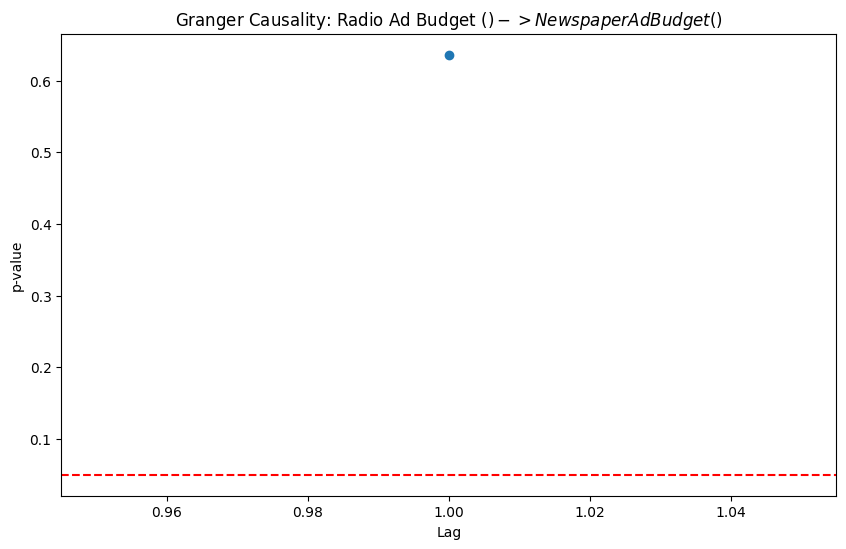

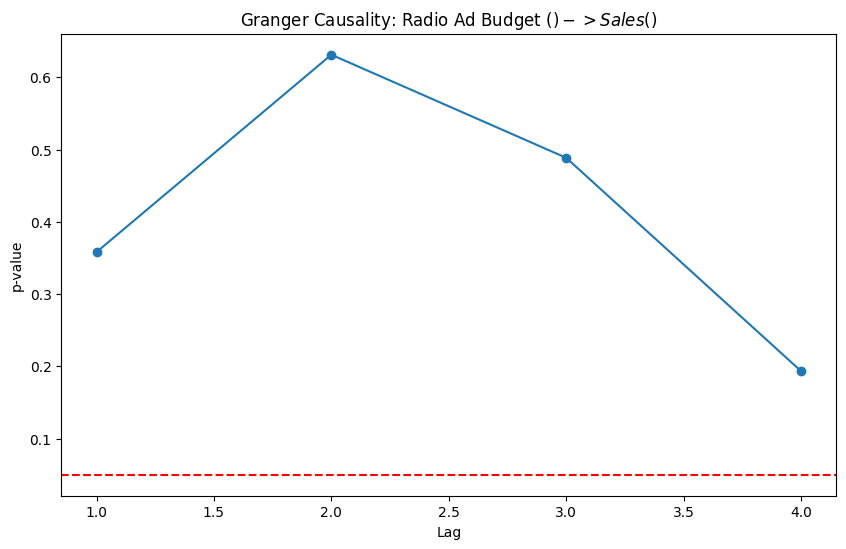

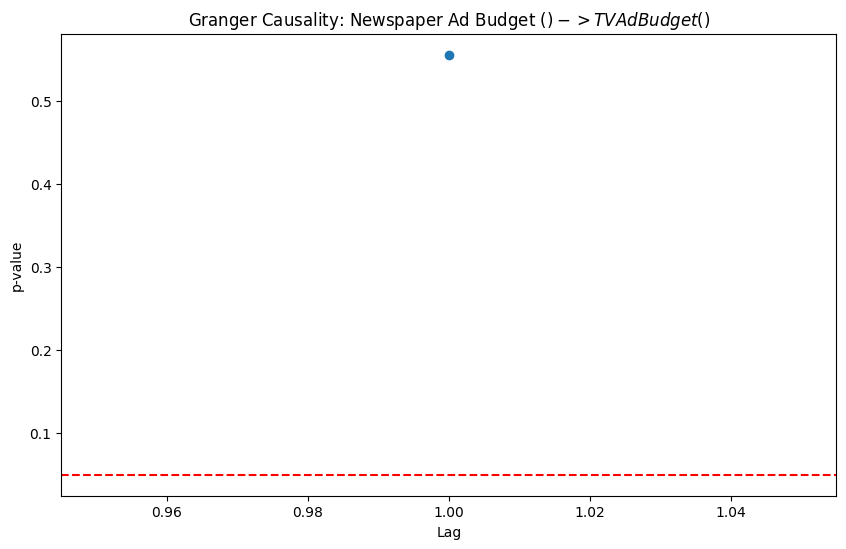

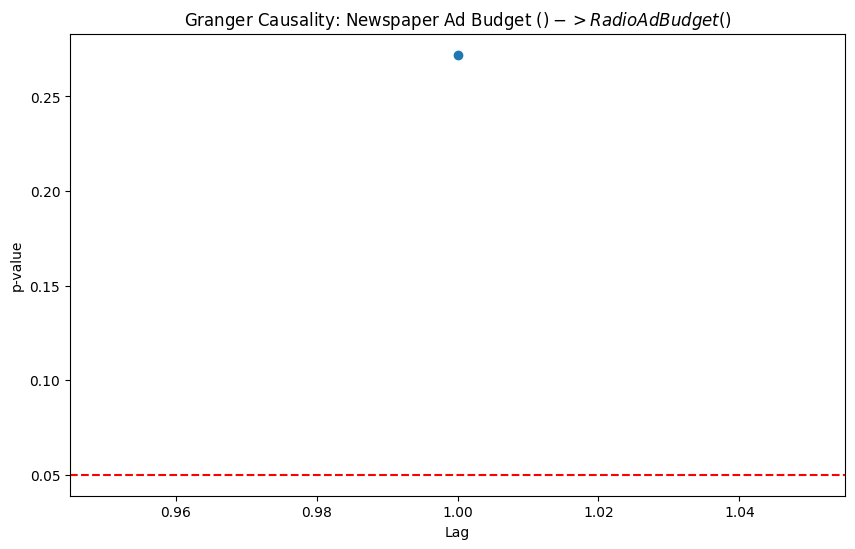

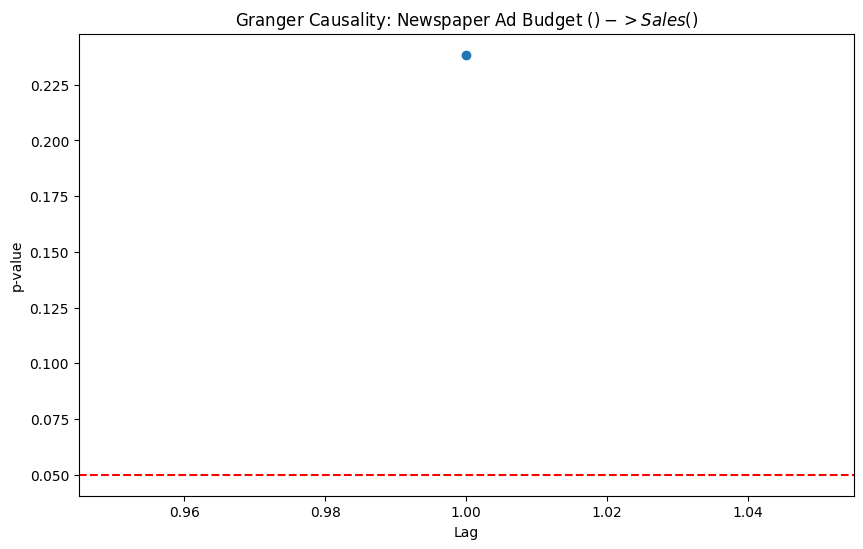

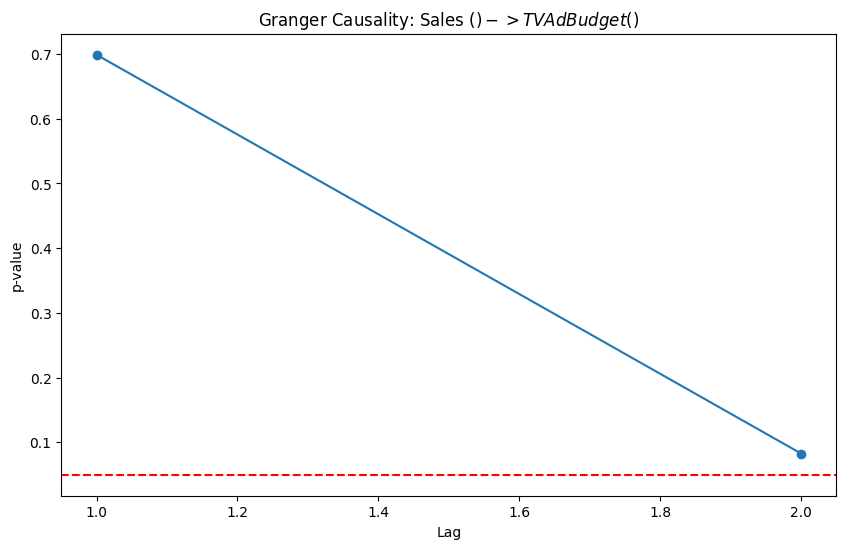

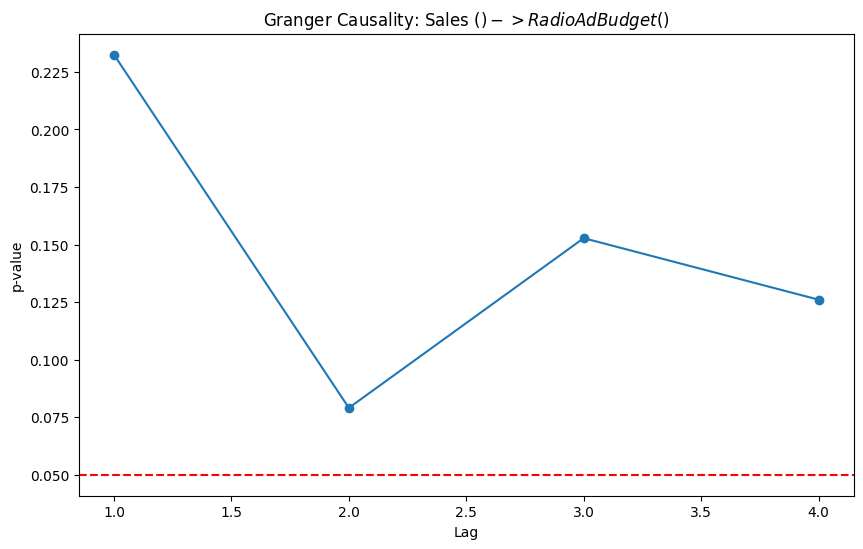

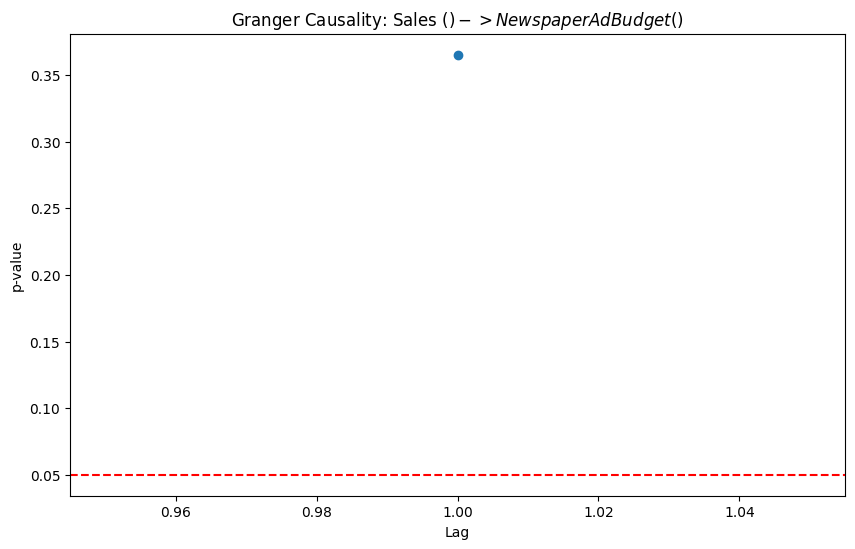


Granger Causality: TV Ad Budget ($) -> Radio Ad Budget ($)
Optimal lag: 2
Significant: True
p-values: [0.22709901928647683, 0.004145385839615909]

Granger Causality: TV Ad Budget ($) -> Newspaper Ad Budget ($)
Optimal lag: 1
Significant: False
p-values: [0.46274126959220974]

Granger Causality: TV Ad Budget ($) -> Sales ($)
Optimal lag: 2
Significant: True
p-values: [0.587195685967231, 0.012628854684702373]

Granger Causality: Radio Ad Budget ($) -> TV Ad Budget ($)
Optimal lag: 2
Significant: False
p-values: [0.5926599756502244, 0.5258491555717677]

Granger Causality: Radio Ad Budget ($) -> Newspaper Ad Budget ($)
Optimal lag: 1
Significant: False
p-values: [0.636114607825748]

Granger Causality: Radio Ad Budget ($) -> Sales ($)
Optimal lag: 4
Significant: False
p-values: [0.3581269004152894, 0.6312686001902378, 0.48859391695967624, 0.19342059244788934]

Granger Causality: Newspaper Ad Budget ($) -> TV Ad Budget ($)
Optimal lag: 1
Significant: False
p-values: [0.5556149513940483]

Gr

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import aic, bic

def optimal_lag(data, max_lag):
    model = VAR(data)
    results = {}
    for lag in range(1, max_lag + 1):
        result = model.fit(lag)
        results[lag] = result.aic
    return min(results, key=results.get)

def granger_causality(data, variables, max_lag=12, alpha=0.05):
    results = {}
    for i in range(len(variables)):
        for j in range(len(variables)):
            if i != j:
                pair = (variables[i], variables[j])
                opt_lag = optimal_lag(data[[variables[i], variables[j]]], max_lag)
                granger_result = grangercausalitytests(data[[variables[i], variables[j]]], maxlag=opt_lag, verbose=False)
                p_values = [granger_result[lag][0]['ssr_ftest'][1] for lag in range(1, opt_lag+1)]
                
                results[pair] = {
                    'optimal_lag': opt_lag,
                    'p_values': p_values,
                    'significant': any(p < alpha for p in p_values)
                }
                
                plt.figure(figsize=(10, 6))
                plt.plot(range(1, opt_lag+1), p_values, marker='o')
                plt.axhline(y=alpha, color='r', linestyle='--')
                plt.title(f'Granger Causality: {variables[i]} -> {variables[j]}')
                plt.xlabel('Lag')
                plt.ylabel('p-value')
                plt.show()
    
    return results

# 그랜저 인과관계 분석 수행
results = granger_causality(df, variables)

# 결과 출력
for pair, result in results.items():
    print(f"\nGranger Causality: {pair[0]} -> {pair[1]}")
    print(f"Optimal lag: {result['optimal_lag']}")
    print(f"Significant: {result['significant']}")
    print(f"p-values: {result['p_values']}")

### TRAIN/TEST SPLIT

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# 데이터 로드
df = pd.read_csv("./Data/Advertising Budget and Sales.csv")
df = df[['TV Ad Budget ($)', 'Sales ($)']]

df['Sales ($)'] = df['Sales ($)'] / df['Sales ($)'].iloc[0]
df['TV Ad Budget ($)'] = df['TV Ad Budget ($)'] / df['TV Ad Budget ($)'].iloc[0]

df.columns = ['tv', 'sales'] # 간단하게 이름 변경

# 데이터 분할 (80% 훈련, 20% 테스트)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

train.shape, test.shape

((160, 2), (40, 2))

In [233]:
train.head()

,tv,sales
0,1.000000,1.000000
1,0.193394,0.470588
2,0.074750,0.420814
3,0.658409,0.837104
4,0.785745,0.583710


In [234]:
test.head()

,tv,sales
160,0.749674,0.651584
161,0.372447,0.601810
162,0.818774,0.674208
163,0.710561,0.814480
164,0.509344,0.538462


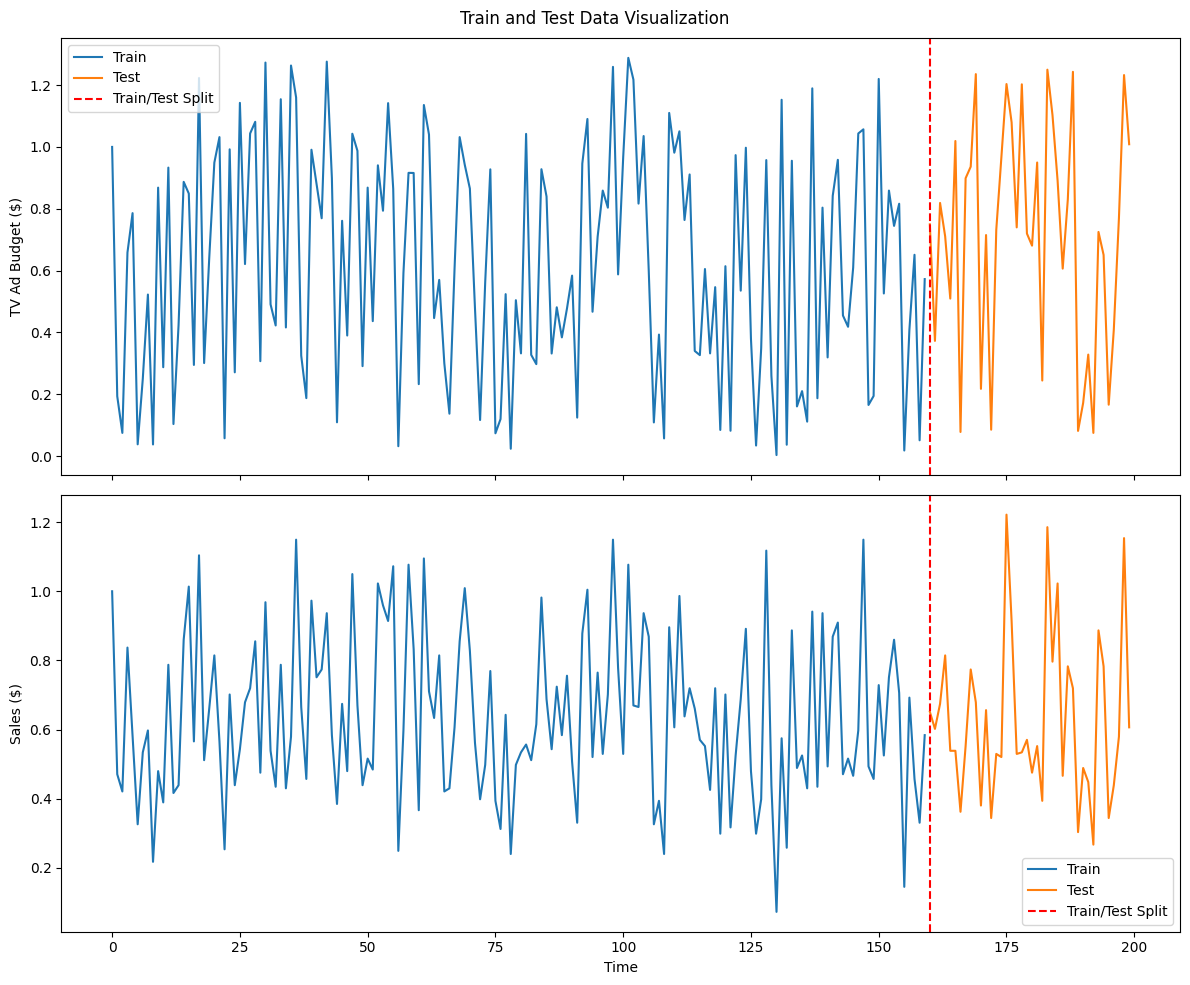

In [235]:
# 그래프 설정
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Train and Test Data Visualization')

# TV Ad Budget 그래프
ax1.plot(df.index[:train_size], train['tv'], label='Train')
ax1.plot(df.index[train_size:], test['tv'], label='Test')
ax1.axvline(x=train_size, color='r', linestyle='--', label='Train/Test Split')
ax1.set_ylabel('TV Ad Budget ($)')
ax1.legend()

# Sales 그래프
ax2.plot(df.index[:train_size], train['sales'], label='Train')
ax2.plot(df.index[train_size:], test['sales'], label='Test')
ax2.axvline(x=train_size, color='r', linestyle='--', label='Train/Test Split')
ax2.set_ylabel('Sales ($)')
ax2.legend()

# x축 레이블 설정
ax2.set_xlabel('Time')

plt.tight_layout()
plt.show()

In [274]:
# USING VAR
lag = 2

# VAR 모델
model_var = VAR(train)
results_var = model_var.fit(lag)

# VAR 동적 예측
forecast_var = []
forecast_input_var = train.values[-lag:]

for i in range(len(test)):
    fc = results_var.forecast(forecast_input_var, steps=1)
    forecast_var.append(fc[0])
    
    # 실제 test 데이터의 이전 lag 값으로 forecast_input_var 업데이트
    if i + 1 < len(test):
        forecast_input_var = np.vstack([forecast_input_var[1:], test.iloc[i].values])
    
forecast_var = np.array(forecast_var)
rmse_var_sales = sqrt(mean_squared_error(test['sales'], forecast_var[:, 1]))
mae_var_sales = mean_absolute_error(test['sales'], forecast_var[:, 1])
mse_var_sales = mean_squared_error(test['sales'], forecast_var[:, 1])
rmse_var_sales, mae_var_sales, mse_var_sales

(0.23430621559986825, 0.19481189362112145, 0.054899402668731945)

In [275]:
train_sales = train['sales']
test_sales = test['sales']

In [276]:
# ARIMA 모델
model_arima = ARIMA(train_sales, order=(lag, 0, 0))
results_arima = model_arima.fit()

# 동적 예측을 위한 ARIMA
forecast_arima_dynamic = []
history = train_sales.tolist()

for t in range(len(test_sales)):
    model_arima_dynamic = ARIMA(history, order=(lag, 0, 0))
    model_fit_dynamic = model_arima_dynamic.fit()
    yhat = model_fit_dynamic.forecast(steps=1)[0]
    forecast_arima_dynamic.append(yhat)
    history.append(test_sales.iloc[t])

rmse_arima_sales_dynamic = sqrt(mean_squared_error(test_sales, forecast_arima_dynamic))
mae_arima_sales_dynamic = mean_absolute_error(test_sales, forecast_arima_dynamic)
mse_arima_sales_dynamic = mean_squared_error(test_sales, forecast_arima_dynamic)
# forecast_arima_dynamic

In [279]:
print("\nModel Comparison:")
print(f"VAR Model RMSE: {rmse_var_sales:.5f}")
print(f"VAR Model MSE: {mse_var_sales:.5f}")
print(f"VAR Model MAE: {mae_var_sales:.5f}")
print("-"*50)
print(f"ARIMA Model RMSE: {rmse_arima_sales_dynamic:.5f}")
print(f"ARIMA Model MSE: {mse_arima_sales_dynamic:.5f}")
print(f"ARIMA Model MAE: {mae_arima_sales_dynamic:.5f}")


Model Comparison:
VAR Model RMSE: 0.23431
VAR Model MSE: 0.05490
VAR Model MAE: 0.19481
--------------------------------------------------
ARIMA Model RMSE: 0.23493
ARIMA Model MSE: 0.05519
ARIMA Model MAE: 0.18524


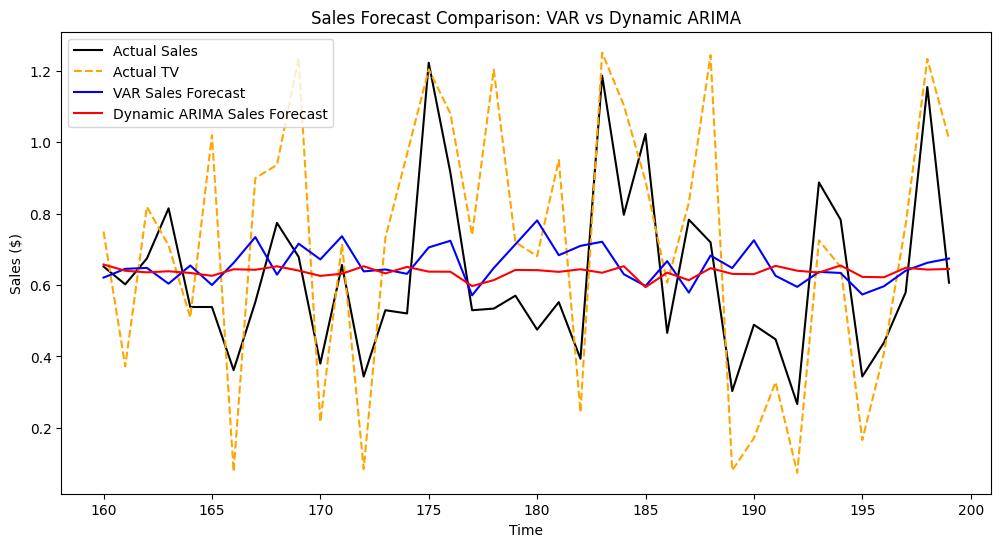

In [278]:
# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.sales, label='Actual Sales', color='black')
plt.plot(test.index, test.tv, label='Actual TV', color='orange', linestyle = '--')

plt.plot(test.index, forecast_var[:, 1], label='VAR Sales Forecast', color='blue')
plt.plot(test.index, forecast_arima_dynamic, label='Dynamic ARIMA Sales Forecast', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Sales ($)')
plt.title('Sales Forecast Comparison: VAR vs Dynamic ARIMA')
plt.show()

---

In [101]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_csv("./Data/Advertising Budget and Sales.csv")
# 데이터 분할 (80% 훈련, 20% 테스트)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# 그랜저 인과성 테스트
max_lag = 10
variables = ['TV Ad Budget ($)', 'Radio Ad Budget ($)', 'Newspaper Ad Budget ($)', 'Sales ($)']

df.head()

,TV Ad Budget ($),Radio Ad Budget ($),Newspaper Ad Budget ($),Sales ($)
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [102]:
causality_results = {}
for i in range(len(variables)):
    for j in range(len(variables)):
        if i != j:
            print(variables[i], "->", variables[j])
            test_result = grangercausalitytests(train[[variables[i], variables[j]]], maxlag=max_lag, verbose=False)
            causality_results[(variables[i], variables[j])] = [test_result[i+1][0]['ssr_ftest'][1] for i in range(max_lag)]

# 그랜저 인과성이 있는 변수 선택 (p-value < 0.05)
causal_vars = set()
for (cause, effect), p_values in causality_results.items():
    if effect == 'Sales ($)' and any(p < 0.05 for p in p_values):
        causal_vars.add(cause)

causal_vars.add('Sales ($)')  # 종속 변수 추가
causal_vars = list(causal_vars)

# 1. 그랜저 인과성 기반 VAR 모델
model_var_causal = VAR(train[causal_vars])
results_var_causal = model_var_causal.fit(maxlags=5, ic='aic')
results_var_causal

TV Ad Budget ($) -> Radio Ad Budget ($)
TV Ad Budget ($) -> Newspaper Ad Budget ($)
TV Ad Budget ($) -> Sales ($)
Radio Ad Budget ($) -> TV Ad Budget ($)
Radio Ad Budget ($) -> Newspaper Ad Budget ($)
Radio Ad Budget ($) -> Sales ($)
Newspaper Ad Budget ($) -> TV Ad Budget ($)
Newspaper Ad Budget ($) -> Radio Ad Budget ($)
Newspaper Ad Budget ($) -> Sales ($)
Sales ($) -> TV Ad Budget ($)
Sales ($) -> Radio Ad Budget ($)
Sales ($) -> Newspaper Ad Budget ($)


---

BACKUP

In [76]:
from pmdarima import auto_arima


# SARIMAX 모델
# 외생 변수(exogenous variable)를 포함한 auto_arima 실행
model_auto = auto_arima(train['Sales ($)'], 
                           exogenous=train[['TV Ad Budget ($)']],  # 외생 변수
                           start_p=0, start_q=0,
                           max_p=5, max_q=5,
                           m=1,  # 계절성이 없는 경우 1로 설정
                           d=None,  # 차분 차수를 자동으로 결정
                           seasonal=False,  # 계절성이 없는 경우 False
                           start_P=0, start_Q=0,
                           max_P=5, max_Q=5, max_D=5,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)


# 롤링 예측 수행
forecast_sarimax = []
for i in range(len(test)):
    fc = model_sarimax.predict(n_periods=1, X=test[['TV Ad Budget ($)']].iloc[i:i+1])
    forecast_sarimax.append(fc)
    model_sarimax.update(test['Sales ($)'].iloc[i], X=test[['TV Ad Budget ($)']].iloc[i:i+1])
forecast_sarimax

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1322.622, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1090.187, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1219.512, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1058.763, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1030.160, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1025.762, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=999.830, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=991.820, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=990.790, Time=0.09 sec


[array([13.95978061]),
 array([13.96095265]),
 array([13.95909032]),
 array([13.96186557]),
 array([13.97437897]),
 array([13.96799401]),
 array([13.96165045]),
 array([13.94342068]),
 array([13.93810424]),
 array([13.94771372]),
 array([13.95087344]),
 array([13.93413412]),
 array([13.93574791]),
 array([13.91681266]),
 array([13.91017432]),
 array([13.90298067]),
 array([13.94193639]),
 array([13.96052832]),
 array([13.95384095]),
 array([13.94748697]),
 array([13.94353354]),
 array([13.93342676]),
 array([13.92835712]),
 array([13.91311338]),
 array([13.94881887]),
 array([13.95944012]),
 array([13.98438967]),
 array([13.97372648]),
 array([13.98332717]),
 array([13.98882134]),
 array([13.96799868]),
 array([13.9589709]),
 array([13.94743708]),
 array([13.92463978]),
 array([13.94067277]),
 array([13.95013483]),
 array([13.93229912]),
 array([13.92044196]),
 array([13.91733712]),
 array([13.94957039])]

In [73]:
print(f"ARMIA 모델 RMSE (Sales): {rmse_arima}")

ARMIA 모델 RMSE (Sales): 6.1492789142678355
